# Forest fire

This notebook presents an agent-based model that simulates a forest fire.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to work with a spatial grid and create animations, and perform a parameter sweep.

In [ ]:
pip install agentpy

In [ ]:
# Model design
import agentpy as ap

# Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

## About the model

The model ist based on the [NetLogo FireSimple model](http://ccl.northwestern.edu/netlogo/models/FireSimple) by Uri Wilensky and William Rand, who describe it as follows:

> "This model simulates the spread of a fire through a forest. It shows that the fire's chance of reaching the right edge of the forest depends critically on the density of trees. This is an example of a common feature of complex systems, the presence of a non-linear threshold or critical parameter. [...]
>
> The fire starts on the left edge of the forest, and spreads to neighboring trees. The fire spreads in four directions: north, east, south, and west.
>
>The model assumes there is no wind. So, the fire must have trees along its path in order to advance. That is, the fire cannot skip over an unwooded area (patch), so such a patch blocks the fire's motion in that direction."

## Model definition

In [ ]:
class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Burned, None
        self.agents.condition = 0

        # Start some first fire positions any where in forest
        if self.p.fire_pos == 0:
          tmp = 0
          step = 100;
          s = int(self.p.size)
          while tmp < self.p.fire_size*5:
            pos = np.random.randint(s,size=(2,1))
            if self.forest.agents[pos[0],pos[1]].condition != None:
              tmp = tmp+1
              self.forest.agents[pos[0],pos[1]].condition = 1
            step = step-1;
            if step == 0:
              break
        else:
          center, forest_size, fire_size  = int(self.p.size/2), self.p.size, self.p.fire_size
          if self.p.fire_pos == 1:
            unfortunate_trees = self.forest.agents[0:self.p.size, 0:2]
          elif self.p.fire_pos == 2:
            unfortunate_trees = self.forest.agents[forest_size-2*fire_size : forest_size, forest_size-2*fire_size : forest_size]
          elif self.p.fire_pos == 3:
            unfortunate_trees = self.forest.agents[center-fire_size: center+fire_size, center-fire_size: center+fire_size]
          unfortunate_trees.condition = 1

        # Build fences in forest
        if self.p.fence == True:
          fence_pos, fence = 9,9 #
          while(fence_pos < self.p.size):
            fence_vertical = self.forest.agents[0:self.p.size, fence_pos]
            fence_horizontal = self.forest.agents[fence_pos, 0:self.p.size]
            fence_vertical.condition, fence_horizontal.condition = 3, 3
            fence_pos = fence_pos + fence

    def step(self):

        # Select burning trees
        burning_trees = self.agents.select(self.agents.condition == 1)

        # Spread fire
        for tree in burning_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            tree.condition = 2 # Tree burns out

        # Stop simulation if no fire is left
        if len(burning_trees) == 0:
            self.stop()

    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of burned trees', burned_trees / len(self.agents))

## Single-run animation

In [ ]:
# Define parameters
parameters = {
    'Tree density': 0.6, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 100,
    'fence': True, # True or False
    'fire_size': 5, # fire_size is number of starting random fire positions;
    'fire_pos': 1, # random = 0, left = 1 ,corner = 2, center = 3
}

In [ ]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', 3:'#d1d426', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")

fig, ax = plt.subplots()
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

In [ ]:
parameters

{'Tree density': 0.6,
 'size': 50,
 'steps': 100,
 'fence': True,
 'fire_size': 5,
 'fire_pos': 2}

## No fence -

In [ ]:
# Prepare parameter sample
parameters1 = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 50,
    'steps': 100,
    'fence': 0,
    'fire_size': 3, # fire_size is number of starting random fire positions;
    'fire_pos': 0, #ap.IntRange(0,3), # random = 0, left = 1 ,corner = 2, center = 3
}

sample1 = ap.Sample(parameters1, n=5)
exp = ap.Experiment(ForestModel, sample1, iterations=40)
results1 = exp.run()
# Save and load data
results1.save(exp_name='Random')
results1 = ap.DataDict.load('Random')

Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:16.424701
Data saved to ap_output/Random_1
Loading from directory ap_output/Random_1/
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful
Loading parameters_constants.json - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


In [ ]:
parameters2 = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 50,
    'steps': 100,
    'fence': True,
    'fire_size': 3, # fire_size is number of starting random fire positions;
    'fire_pos': 1, #ap.IntRange(0,3), # random = 0, left = 1 ,corner = 2, center = 3
}

sample2 = ap.Sample(parameters2, n=5)
exp = ap.Experiment(ForestModel, sample2, iterations=40)
results2 = exp.run()

# Save and load data
results2.save(exp_name='Left')
results2 = ap.DataDict.load('Left')

Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:08.101577
Data saved to ap_output/Left_1
Loading from directory ap_output/Left_1/
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful
Loading parameters_constants.json - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


In [ ]:
parameters3 = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 50,
    'steps': 100,
    'fence': False,
    'fire_size': 3, # fire_size is number of starting random fire positions;
    'fire_pos': 2, #ap.IntRange(0,3), # random = 0, left = 1 ,corner = 2, center = 3
}

sample3 = ap.Sample(parameters3, n=5)
exp = ap.Experiment(ForestModel, sample3, iterations=40)
results3 = exp.run()

# Save and load data
results3.save(exp_name='Corner')
results3 = ap.DataDict.load('Corner')


Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:10.287553
Data saved to ap_output/Corner_1
Loading from directory ap_output/Corner_1/
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful
Loading parameters_constants.json - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


In [ ]:
parameters4 = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 50,
    'steps': 100,
    'fence': False,
    'fire_size': 3, # fire_size is number of starting random fire positions;
    'fire_pos': 3, #ap.IntRange(0,3), # random = 0, left = 1 ,corner = 2, center = 3
}

sample4 = ap.Sample(parameters4, n=5)
exp = ap.Experiment(ForestModel, sample4, iterations=40)
results4 = exp.run()

# Save and load data
results4.save(exp_name='Center')
results4 = ap.DataDict.load('Center')

Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:09.673041
Data saved to ap_output/Center_1
Loading from directory ap_output/Center_1/
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful
Loading parameters_constants.json - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


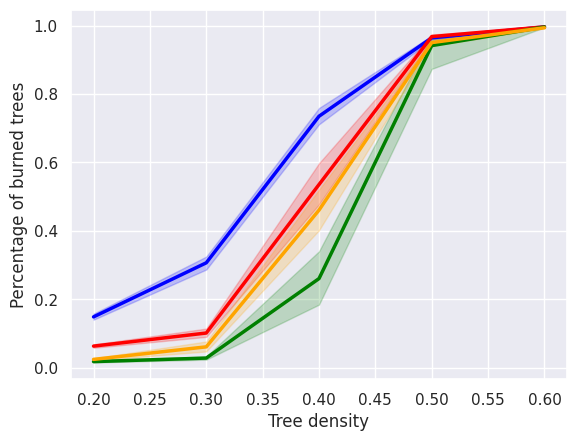

In [ ]:
sns.set_theme()
sns.lineplot(
    data=results1.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees',
    color='blue', linewidth=2.5,legend='auto'
);
sns.lineplot(
    data=results2.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees',
    color='red', linewidth=2.5,legend='auto'
);
sns.lineplot(
    data=results3.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees',
    color='green', linewidth=2.5,legend='auto'
);
sns.lineplot(
    data=results4.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees',
    color='orange', linewidth=2.5,legend='auto'
);

In [ ]:
# Prepare parameter sample
parameters5 = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 50,
    'steps': 100,
    'fence': True,
    'fire_size': 3, # fire_size is number of starting random fire positions;
    'fire_pos': 0, #ap.IntRange(0,3), # random = 0, left = 1 ,corner = 2, center = 3
}

sample5 = ap.Sample(parameters5, n=5)
exp = ap.Experiment(ForestModel, sample5, iterations=40)
results5 = exp.run()
# Save and load data
results5.save(exp_name='FRandom')
results5 = ap.DataDict.load('FRandom')

Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:09.479468
Data saved to ap_output/FRandom_1
Loading from directory ap_output/FRandom_1/
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful
Loading parameters_constants.json - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


In [ ]:
parameters6 = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 50,
    'steps': 100,
    'fence': True,
    'fire_size': 3, # fire_size is number of starting random fire positions;
    'fire_pos': 1, #ap.IntRange(0,3), # random = 0, left = 1 ,corner = 2, center = 3
}

sample6 = ap.Sample(parameters6, n=5)
exp = ap.Experiment(ForestModel, sample6, iterations=40)
results6 = exp.run()
# Save and load data
results6.save(exp_name='FLeft')
results6 = ap.DataDict.load('FLeft')

Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:09.357229
Data saved to ap_output/FLeft_1
Loading from directory ap_output/FLeft_1/
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful
Loading parameters_constants.json - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


In [ ]:
parameters7 = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 50,
    'steps': 100,
    'fence': True,
    'fire_size': 3, # fire_size is number of starting random fire positions;
    'fire_pos': 2, #ap.IntRange(0,3), # random = 0, left = 1 ,corner = 2, center = 3
}

sample7 = ap.Sample(parameters7, n=5)
exp = ap.Experiment(ForestModel, sample7, iterations=40)
results7 = exp.run()
# Save and load data
results7.save(exp_name='FCorner')
results8 = ap.DataDict.load('FCorner')

Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:10.588983
Data saved to ap_output/FCorner_1
Loading from directory ap_output/FCorner_1/
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful
Loading parameters_constants.json - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


In [ ]:
parameters8 = {
    'Tree density': ap.Range(0.2, 0.6),
    'size': 50,
    'steps': 100,
    'fence': True,
    'fire_size': 3, # fire_size is number of starting random fire positions;
    'fire_pos': 3, #ap.IntRange(0,3), # random = 0, left = 1 ,corner = 2, center = 3
}

sample8 = ap.Sample(parameters8, n=5)
exp = ap.Experiment(ForestModel, sample6, iterations=40)
results8 = exp.run()
# Save and load data
results8.save(exp_name='FCenter')
results8 = ap.DataDict.load('FCenter')

Scheduled runs: 200
Completed: 200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:05.104560
Data saved to ap_output/FCenter_1
Loading from directory ap_output/FCenter_1/
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful
Loading parameters_constants.json - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


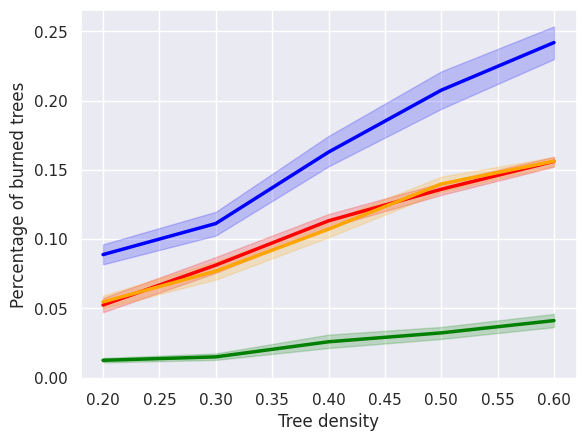

In [ ]:
sns.set_theme()
sns.lineplot(
    data=results5.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees',
    color='blue', linewidth=2.5,legend='auto'
);
sns.lineplot(
    data=results6.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees',
    color='red', linewidth=2.5,legend='auto'
);
sns.lineplot(
    data=results7.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees',
    color='green', linewidth=2.5,legend='auto'
);
sns.lineplot(
    data=results8.arrange_reporters(),
    x='Tree density',
    y='Percentage of burned trees',
    color='orange', linewidth=2.5,legend='auto'
);